In [3]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

356098


In [4]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

import pickle

In [5]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
# figure_folder
figure_folder = os.path.join(analysis_folder, 'saved_figures_20231018')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907
-- 17 folders, 325 fovs detected.


In [6]:
color_usage_filename = os.path.join(analysis_folder, "Color_Usage.csv")
color_usage_df = data_organization.Color_Usage(color_usage_filename)

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Color_Usage.csv


In [7]:
save_folder = analysis_folder
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
import re
match = re.match(r'.*_([0-9]+).hdf5', os.path.basename(save_filenames[0]), ).groups()[0]
save_filenames = [_f for _f in sorted(save_filenames, 
                                      key=lambda _v:int(re.match(r'.*_([0-9]+).hdf5', os.path.basename(_v), ).groups()[0]))]

In [9]:
processed_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                       if '_processed_info.pkl' in _fl]
processed_filenames = [_f for _f in sorted(processed_filenames, 
                                      key=lambda _v:int(re.match(r'.*_([0-9]+)_processed_info.pkl', os.path.basename(_v), ).groups()[0]))]

print(len(processed_filenames))

116


In [10]:
# load infos:
all_intbc_ims = []
all_edit_ims = []
for _fl in processed_filenames:
    #print(_fl)
    _fov_info = pickle.load(open(_fl, 'rb'))
    for _info in _fov_info:
        all_intbc_ims.append(_info['intbc_ims'])
        all_edit_ims.append(_info['edit_ims'])
    # extract all edits ims
    print(f" loaded {len(_fov_info)} from file: {os.path.basename(_fl)}")
print(f"- {len(all_intbc_ims)} in total")

 loaded 47 from file: Conv_zscan_003_processed_info.pkl
 loaded 63 from file: Conv_zscan_004_processed_info.pkl
 loaded 23 from file: Conv_zscan_005_processed_info.pkl
 loaded 62 from file: Conv_zscan_006_processed_info.pkl
 loaded 58 from file: Conv_zscan_007_processed_info.pkl
 loaded 53 from file: Conv_zscan_008_processed_info.pkl
 loaded 11 from file: Conv_zscan_009_processed_info.pkl
 loaded 58 from file: Conv_zscan_010_processed_info.pkl
 loaded 34 from file: Conv_zscan_011_processed_info.pkl
 loaded 30 from file: Conv_zscan_012_processed_info.pkl
 loaded 89 from file: Conv_zscan_013_processed_info.pkl
 loaded 38 from file: Conv_zscan_014_processed_info.pkl
 loaded 25 from file: Conv_zscan_015_processed_info.pkl
 loaded 29 from file: Conv_zscan_016_processed_info.pkl
 loaded 51 from file: Conv_zscan_017_processed_info.pkl
 loaded 22 from file: Conv_zscan_018_processed_info.pkl
 loaded 84 from file: Conv_zscan_019_processed_info.pkl
 loaded 54 from file: Conv_zscan_020_processed_i

In [11]:
len(all_intbc_ims)

6895

In [12]:
# Save to temp location
temp_folder = r'/lab/solexa_weissman/puzheng/PE_LT/Analysis/0913_top8'
if not os.path.isdir(temp_folder):
    os.makedirs(temp_folder)
# ims files:
intbcIm_filename = os.path.join(temp_folder, 'intbc_ims.npy')
editIm_filename = os.path.join(temp_folder, 'edit_ims.npy')
print(intbcIm_filename, editIm_filename)
np.save(intbcIm_filename, all_intbc_ims)
np.save(editIm_filename, all_edit_ims)

/lab/solexa_weissman/puzheng/PE_LT/Analysis/0913_top8/intbc_ims.npy /lab/solexa_weissman/puzheng/PE_LT/Analysis/0913_top8/edit_ims.npy


In [10]:
# reload from here:
temp_folder = r'/lab/solexa_weissman/puzheng/PE_LT/Analysis/0913_top8'
if 'all_intbc_ims' not in locals():
    
    intbcIm_filename = os.path.join(temp_folder, 'intbc_ims.npy')
    editIm_filename = os.path.join(temp_folder, 'edit_ims.npy')
    print(intbcIm_filename, editIm_filename)
    all_intbc_ims = np.load(intbcIm_filename, )
    all_edit_ims = np.load(editIm_filename, )


# Load codebook

In [13]:
codebook_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/NewTargetSites/IntBC_MERFISH/full_codebook.csv'
codebook = pd.read_csv(codebook_filename)

In [14]:
# mimic MERLin Optimization, prepare data:
class Optimization_decode():
    """
    An analysis class for decoding MERFISH data
    """
    def __init__(self, codebook_filename, 
                 color_usage_filename=None,
                 verbose=True,
                 ):
        # direct inputs
        self.verbose = verbose
        # load inputs
        self.codebook_filename = codebook_filename
        self._load_codebook()
        self.color_usage_filename = color_usage_filename
        self._load_color_usage()
        

    def _load_color_usage(self):
        """
        Load color usage from file
        """
        if not hasattr(self, 'color_usage_df') or self.color_usage_df is None:
            if self.verbose:
                print(f"-- loading color usage from file: {self.color_usage_filename}")
            self.color_usage_df = data_organization.Color_Usage(self.color_usage_filename, verbose=False)
        else:
            pass
    
    def _load_codebook(self):
        """
        Load codebook from file
        """
        if not hasattr(self, 'codebook') or self.codebook is None:
            if self.verbose:
                print(f"-- loading codebook from file: {self.codebook_filename}")
            self.codebook = pd.read_csv(self.codebook_filename)
        else:
            pass
    
    def _load_images(self, cropped_ims):
        """
        include loaded images into the class, for now its a test case
        """
        # add loaded images
        self.ims = np.array(cropped_ims)
        return
    
    def _init_scale_factors(
            self, 
            n_bins=2000,      
            scale_max=0.99,
        ) -> np.ndarray:
        """
        initialize scale factors
        """
        self.scale_factors = np.ones((self.ims.shape[0], self.ims.shape[1]), dtype=np.float32)
        data_type = self.ims.dtype
        ## TODO: add reading for bits information
        bits = np.arange(self.ims.shape[1])
        scale_factors, backgrounds = [], []
        for bit in bits:
            # calculate cumulative histogram
            counts, intensities =  np.histogram(np.array(all_intbc_ims)[:,bit], bins=np.arange(np.iinfo(data_type).min, 
                                                                                np.iinfo(data_type).max+1,
                                                                                (np.iinfo(data_type).max+1 - np.iinfo(data_type).min)/n_bins))
                                                                                
            intensities = (intensities[:-1] + intensities[1:]) / 2
            cumsum_counts = np.cumsum(counts)
            cumsum_counts = cumsum_counts / cumsum_counts[-1]

            # calculate background
            background = find_image_background(np.array(all_intbc_ims)[:,bit], )
            backgrounds.append(background)
            scaling_factor = np.ceil(intensities[np.argmin(np.abs(cumsum_counts - scale_max))])
            #scale_factors.append(max(scaling_factor - background, 1))
            scale_factors.append(scaling_factor+1)
            print(bit, scaling_factor, background) 
        # add attribute
        self.scale_factors = np.array(scale_factors)
        self.backgrounds = np.array(backgrounds)
        return np.array(scale_factors), np.array(backgrounds)
        
    def _get_previous_scale_factors(self) -> np.ndarray:
        if 'previous_iteration' not in self.parameters:
            scaleFactors = self._init_scale_factors()
        else:
            previousIteration = self.dataSet.load_analysis_task(
                self.parameters['previous_iteration'])
            scaleFactors = previousIteration.get_scale_factors()

        return scaleFactors

    def _get_previous_backgrounds(self) -> np.ndarray:
        if 'previous_iteration' not in self.parameters:
            backgrounds = np.zeros(self.get_codebook().get_bit_count())
        else:
            previousIteration = self.dataSet.load_analysis_task(
                self.parameters['previous_iteration'])
            backgrounds = previousIteration.get_backgrounds()

        return backgrounds
    

        

In [228]:
from scipy.stats import scoreatpercentile

In [229]:
# test case:
optimize_obj = Optimization_decode(codebook_filename, color_usage_filename, verbose=True)
optimize_obj._load_images(all_intbc_ims)
optimize_obj._init_scale_factors()

-- loading codebook from file: /lab/solexa_weissman/puzheng/MERFISH_Probes/PE_TS/NewTargetSites/IntBC_MERFISH/full_codebook.csv
-- loading color usage from file: /lab/weissman_imaging/puzheng/PE_LT/20230913-4T1top8_preEdit_400k0907/Analysis/Color_Usage.csv
0 7357.0 2345.0
1 6079.0 2605.0
2 4867.0 2435.0
3 3097.0 1235.0
4 5063.0 2205.0
5 4965.0 2625.0
6 3425.0 1585.0
7 2671.0 1995.0
8 5358.0 2875.0
9 3654.0 1635.0
10 4015.0 2255.0
11 5489.0 2925.0
12 4473.0 1425.0
13 3654.0 2205.0
14 5915.0 3035.0
15 3064.0 1355.0
16 4768.0 2255.0
17 5850.0 3015.0
18 4015.0 1705.0
19 3228.0 2025.0
20 6177.0 3085.0


(array([7358., 6080., 4868., 3098., 5064., 4966., 3426., 2672., 5359.,
        3655., 4016., 5490., 4474., 3655., 5916., 3065., 4769., 5851.,
        4016., 3229., 6178.]),
 array([2345., 2605., 2435., 1235., 2205., 2625., 1585., 1995., 2875.,
        1635., 2255., 2925., 1425., 2205., 3035., 1355., 2255., 3015.,
        1705., 2025., 3085.]))

In [240]:
def decode_foci(
    self, 
    imageSeries=None, 
    codebook:pd.DataFrame=None,
    scale_factors:np.ndarray=None,
    backgrounds:np.ndarray=None,
    distance_threshold:int=1,
    magnitute_threshold:int=1,
    lowpass_threshold:int=1,        
    ) -> int:
    """
    Assign barcodes to each foci
    Each imageSeries has been preprocessed and aligned, 
    then according to the scaling factor and background, 
    this focus is normalized into a vector and assigned to specific barcode based on Euclidean distance
    to one of the existing barcode
    """
    # Inputs
    if imageSeries is None:
        # num_foci x num_bits x dx x dy x dz
        imageSeries = self.ims
    if scale_factors is None:
        scale_factors = self.scale_factors
    if backgrounds is None:
        backgrounds = self.backgrounds
    if codebook is None:
        codebook = self.codebook
        _codebook_mat = codebook.iloc[:,1:].values
    # normalize images
    for _i, _images in enumerate(imageSeries):
        #signalSeries = scoreatpercentile(_images.reshape((_images.shape[0],-1)), 95, axis=1)
        signalSeries = _images 
        print(signalSeries.shape)
        
        normalizedSeries = (signalSeries - backgrounds[:,np.newaxis,np.newaxis,np.newaxis]) / scale_factors[:,np.newaxis,np.newaxis,np.newaxis]        
        # calculate Euclidian distance     
        _dists = np.linalg.norm(normalizedSeries[np.newaxis,:] - _codebook_mat[:,:,np.newaxis,np.newaxis,np.newaxis], axis=1)
        print(_dists.shape)
        #print(np.sort(_dists)[0][:30])
        break
    
    return _dists, normalizedSeries

In [241]:
backgroundMag = 1
scaleMag = 1


(21, 15, 15, 15)
(2330, 15, 15, 15)


In [246]:
norm[:,7,7,7], norm[:,8,8,8]

(array([ 0.64446861,  2.60197368, -0.49137223,  0.01904454,  0.3785545 ,
         0.41542489,  0.02539405,  0.5370509 , -0.10617653, -0.01805746,
         0.31175299, -0.03861566, -0.00715244,  0.38932969,  0.65956728,
         0.06492659,  0.60515831, -0.11946676,  1.01294821,  1.71724992,
        -0.21673681]),
 array([ 0.54321827,  0.89457237, -0.28266228,  0.02743706,  0.13408373,
         0.19573097,  0.0040864 ,  0.24775449, -0.0378802 ,  0.00355677,
         0.09586653, -0.0276867 ,  0.02436299,  0.10341997,  0.22751859,
         0.07504078,  0.20696163, -0.09024098,  0.86005976,  0.65159492,
        -0.08352218]))

In [232]:
np.sort(np.max(dists, axis=(1,2,3)))[:5], np.argsort(np.max(dists, axis=(1,2,3)))[:5]#, np.min(np.max(dists, axis=(1,2,3)))

(array([2.56417521, 2.56595058, 2.57480874, 2.57815816, 2.58175734]),
 array([101, 999, 988, 815, 934]))

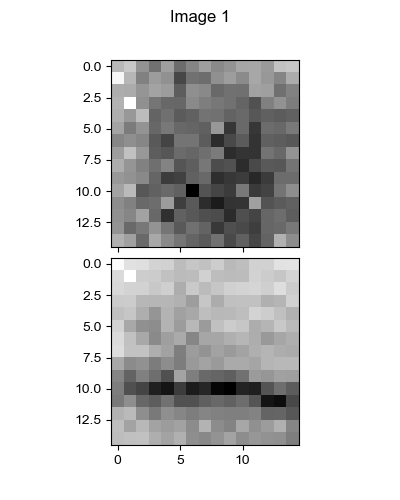

In [233]:
interactive.imshow_mark_3d(dists[np.array([101,815,999])])

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [35]:
cumHist = np.cumsum(all_intbc_ims, axis=1)

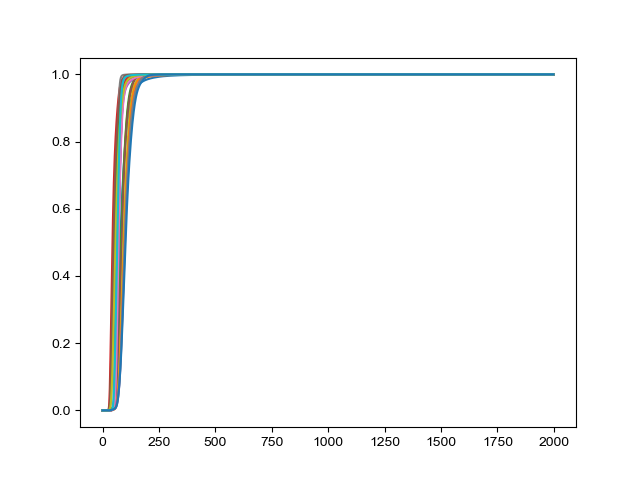

In [98]:
plt.figure()
plt.plot(np.array(all_cumHist).transpose(),)
plt.show()

0 4604.0 2345.0
1 4178.0 2605.0
2 4015.0 2435.0
3 2442.0 1235.0
4 3261.0 2205.0
5 4113.0 2625.0
6 2802.0 1585.0
7 2442.0 1995.0
8 4441.0 2875.0
9 2835.0 1635.0
10 3130.0 2255.0
11 4539.0 2925.0
12 2900.0 1425.0
13 3064.0 2205.0
14 4867.0 3035.0
15 2606.0 1355.0
16 3228.0 2255.0
17 4801.0 3015.0
18 3064.0 1705.0
19 2802.0 2025.0
20 5063.0 3085.0


In [ ]:
def find_image_background(im, dtype=None, bin_size=10, make_plot=False, max_iter=10):
    """Function to calculate image background
    Inputs: 
        im: image, np.ndarray,
        dtype: data type for image, numpy datatype (default: np.uint16) 
        bin_size: size of histogram bin, smaller -> higher precision and longer time,
            float (default: 10)
    Output: 
        _background: determined background level, float
    """
    from scipy.signal import find_peaks
    if dtype is None:
        dtype = im.dtype 
    _cts, _bins = np.histogram(im, 
                               bins=np.arange(np.iinfo(dtype).min, 
                                              np.iinfo(dtype).max,
                                              bin_size)
                               )
    _peaks = []
    # gradually lower height to find at least one peak
    _height = np.size(im)/50
    _iter = 0
    while len(_peaks) == 0:
        _height = _height / 2 
        _peaks, _params = find_peaks(_cts, height=_height)
        _iter += 1
        if _iter > max_iter:
            break
    # select highest peak
    if _iter > max_iter:
        _background = np.nanmedian(im)
    else:
        _sel_peak = _peaks[np.argmax(_params['peak_heights'])]
        # define background as this value
        _background = (_bins[_sel_peak] + _bins[_sel_peak+1]) / 2
    # plot histogram if necessary
    if make_plot:
        import matplotlib.pyplot as plt
        plt.figure(dpi=100)
        plt.hist(np.ravel(im), bins=np.arange(np.iinfo(dtype).min, 
                                              np.iinfo(dtype).max,
                                              bin_size))
        plt.xlim([np.min(im), np.max(im)])     
        plt.show()

    return _background

In [ ]:
len(all_intbc_ims)

1708

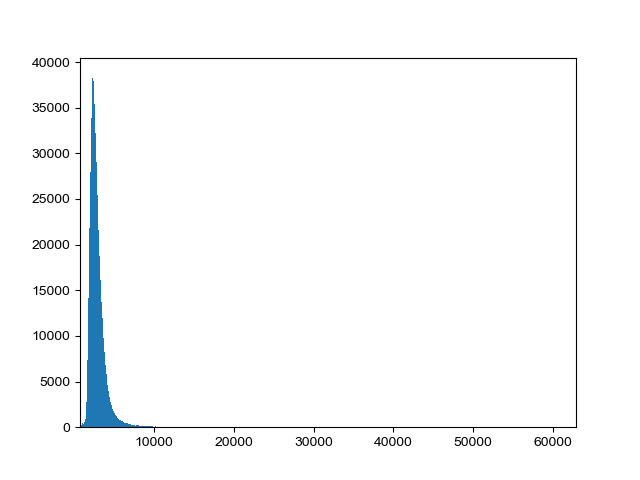

2345.0

In [ ]:
find_image_background(np.array(all_intbc_ims)[:,0], make_plot=True)

In [ ]:
np.iinfo(data_type).max

65535

In [ ]:
pixelHist

(array([5693805,   61808,    6514,    1545,     533,     193,      58,
             29,      10,       5]),
 array([  694. ,  6914.1, 13134.2, 19354.3, 25574.4, 31794.5, 38014.6,
        44234.7, 50454.8, 56674.9, 62895. ]))

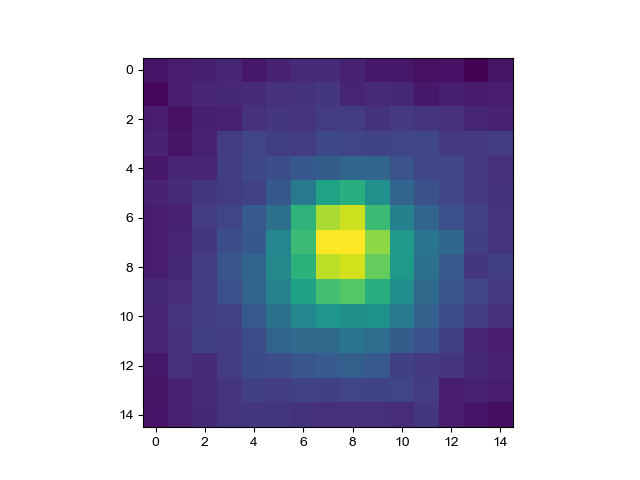

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cumHist[0][0].mean(0))
plt.show()

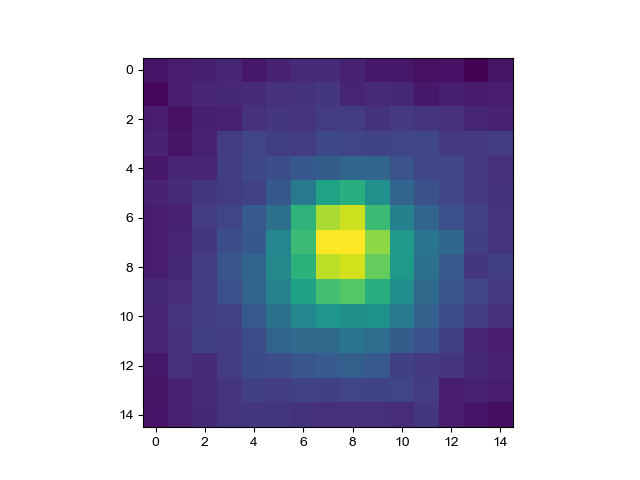

In [ ]:
plt.figure()
plt.imshow(all_intbc_ims[0][0].mean(0))
plt.show()